# Терешенков БВТ2203. Лаб. работа №2. CVAE для генерации на датасете MNIST

In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # Mean and std for MNIST
])


In [5]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
class MNISTCvae(nn.Module):
    def __init__(self, n_classes):
        super(MNISTCvae, self).__init__()
        self.num_classes = n_classes

        self.encoder = nn.Sequential(
            nn.Linear(28 * 28 + n_classes, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 36),
            nn.ReLU(),
            nn.Linear(36, 18)
        )

        self.mu = nn.Linear(18, 9)
        self.logvar = nn.Linear(18, 9)

        self.decoder = nn.Sequential(
            nn.Linear(9 + n_classes, 18),
            nn.ReLU(),
            nn.Linear(18, 36),
            nn.ReLU(),
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    # def encode(self, x, class_num):
    #     class_num = torch.as_tensor(class_num, device=x.device)

    #     class_one_hot = F.one_hot(class_num, num_classes=self.num_classes).float()
    #     class_one_hot = class_one_hot.to(x.device)
    #     x = torch.cat([x, class_one_hot], dim=1)

    #     lat_vector = self.encoder(x)

    #     mu = self.mu(lat_vector)
    #     logsigma = self.logvar(lat_vector)

    #     return mu, logsigma

    # def decode(self, z, class_num):
    #     class_num = torch.as_tensor(class_num, device=z.device)
        
    #     class_one_hot = F.one_hot(class_num, num_classes=self.num_classes).float()
    #     class_one_hot = class_one_hot.to(z.device)
    #     z = torch.cat([z, class_one_hot], dim=1)

    #     reconstructed = self.decoder(z)

    #     return reconstructed
    
    def encode(self, x, class_num):
        class_num = torch.as_tensor(class_num, device=x.device)

        # ensure batch dimension
        if class_num.dim() == 0:
            class_num = class_num.unsqueeze(0)
        if class_num.shape[0] != x.shape[0]:
            class_num = class_num.repeat(x.shape[0])

        class_one_hot = F.one_hot(class_num, num_classes=self.num_classes).float()
        x = torch.cat([x, class_one_hot], dim=1)
        
        lat = self.encoder(x)
        return self.mu(lat), self.logvar(lat)


    def decode(self, z, class_num):
        class_num = torch.as_tensor(class_num, device=z.device)

        # ensure batch dimension
        if class_num.dim() == 0:
            class_num = class_num.unsqueeze(0)
        if class_num.shape[0] != z.shape[0]:
            class_num = class_num.repeat(z.shape[0])

        class_one_hot = F.one_hot(class_num, num_classes=self.num_classes).float()
        z = torch.cat([z, class_one_hot], dim=1)
        
        return self.decoder(z)
    
    def forward(self, x, class_num):
        mu, logsigma = self.encode(x, class_num)

        z = self.reparameterize(mu, logsigma)

        return self.decode(z, class_num), mu, logsigma


In [ ]:
class MNISTCvaeNew(nn.Module):
    def __init__(self, n_classes):
        super(MNISTCvaeNew, self).__init__()
        self.num_classes = n_classes

        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 36)
        )

        self.mu = nn.Linear(36 + n_classes, 18)
        self.logvar = nn.Linear(36 + n_classes, 18)

        self.decoder = nn.Sequential(
            nn.Linear(18 + n_classes, 36),
            nn.ReLU(),
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    # def encode(self, x, class_num):
    #     class_num = torch.as_tensor(class_num, device=x.device)

    #     class_one_hot = F.one_hot(class_num, num_classes=self.num_classes).float()
    #     class_one_hot = class_one_hot.to(x.device)
    #     x = torch.cat([x, class_one_hot], dim=1)

    #     lat_vector = self.encoder(x)

    #     mu = self.mu(lat_vector)
    #     logsigma = self.logvar(lat_vector)

    #     return mu, logsigma

    # def decode(self, z, class_num):
    #     class_num = torch.as_tensor(class_num, device=z.device)
        
    #     class_one_hot = F.one_hot(class_num, num_classes=self.num_classes).float()
    #     class_one_hot = class_one_hot.to(z.device)
    #     z = torch.cat([z, class_one_hot], dim=1)

    #     reconstructed = self.decoder(z)

    #     return reconstructed
    
    def encode(self, x, class_num):
        class_num = torch.as_tensor(class_num, device=x.device)

        if class_num.dim() == 0:
            class_num = class_num.unsqueeze(0)
        if class_num.shape[0] != x.shape[0]:
            class_num = class_num.repeat(x.shape[0])

        class_one_hot = F.one_hot(class_num, num_classes=self.num_classes).float()
        
        lat = self.encoder(x)
        lat = torch.cat([lat, class_one_hot], dim=1)
        
        return self.mu(lat), self.logvar(lat)


    def decode(self, z, class_num):
        class_num = torch.as_tensor(class_num, device=z.device)

        if class_num.dim() == 0:
            class_num = class_num.unsqueeze(0)
        if class_num.shape[0] != z.shape[0]:
            class_num = class_num.repeat(z.shape[0])

        class_one_hot = F.one_hot(class_num, num_classes=self.num_classes).float()
        z = torch.cat([z, class_one_hot], dim=1)
        
        return self.decoder(z)
    
    def forward(self, x, class_num):
        mu, logsigma = self.encode(x, class_num)

        z = self.reparameterize(mu, logsigma)

        return self.decode(z, class_num), mu, logsigma


In [ ]:
def loss_function(recon_logits, x, mu, logvar, reduction='batch'):
    B = x.size(0)
    recon_loss = F.binary_cross_entropy_with_logits(recon_logits, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    if reduction == 'batch':
        return (recon_loss + kld) / B, recon_loss / B, kld / B
    else:
        return recon_loss + kld, recon_loss, kld

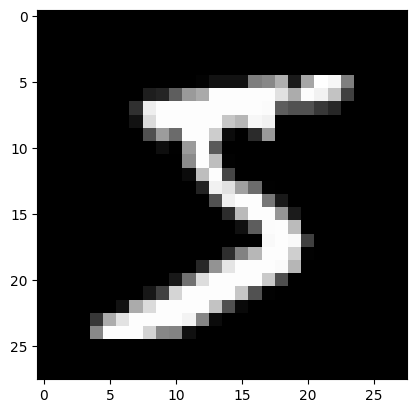

In [10]:
plt.imshow(train_dataset[0][0].numpy().squeeze(), cmap="gray")

In [ ]:
num_classes= 10
c_vae = MNISTCvae(10).to(device)
optimizer = optim.Adam(c_vae.parameters())

In [14]:
n_epochs = 100
train_losses = []

for epoch in range(n_epochs):
    c_vae.train()
    train_losses_per_epoch = []
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        X_batch = X_batch.float()
        X_batch = X_batch.view(X_batch.size(0), -1)

        reconstructed, mu, logsigma = c_vae(X_batch.to(device), y_batch.to(device))

        loss, recon, kld = loss_function(reconstructed.cpu(), X_batch.cpu(), mu.cpu(), logsigma.cpu())
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))
    print(f"Epoch = {epoch}, loss = {np.mean(train_losses_per_epoch)}")

Epoch = 0, loss = 479.2899777345312
Epoch = 1, loss = 477.5499688902898
Epoch = 2, loss = 472.0725086594441
Epoch = 3, loss = 465.2473845004019
Epoch = 4, loss = 461.0217569184456
Epoch = 5, loss = 458.9932244469616
Epoch = 6, loss = 457.79091593858277
Epoch = 7, loss = 456.3706962081161
Epoch = 8, loss = 454.8618468912934
Epoch = 9, loss = 452.95342968776026
Epoch = 10, loss = 450.61494338436165
Epoch = 11, loss = 449.11223115900685
Epoch = 12, loss = 447.83877615532134
Epoch = 13, loss = 446.7910890884237
Epoch = 14, loss = 445.68438844335105
Epoch = 15, loss = 444.4878008096203
Epoch = 16, loss = 443.81057316306305
Epoch = 17, loss = 443.384056465458
Epoch = 18, loss = 442.90254959724604
Epoch = 19, loss = 442.506452580759
Epoch = 20, loss = 442.28850892154395
Epoch = 21, loss = 442.09404268244435
Epoch = 22, loss = 441.9267263514147
Epoch = 23, loss = 441.72037800542836
Epoch = 24, loss = 441.55249605809195
Epoch = 25, loss = 441.355729125456
Epoch = 26, loss = 441.21711405609716
E

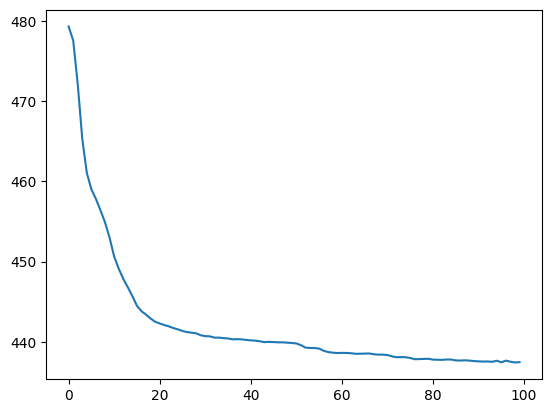

In [ ]:
plt.plot(train_losses)

In [52]:
def generate_batch(model, class_id, n_samples=5, device='cuda'):
    model.eval()

    z = torch.randn(n_samples, 9).to(device)
    labels = torch.full((n_samples,), class_id).to(device)

    with torch.no_grad():
        imgs = model.decode(z, labels)

    imgs = imgs.view(n_samples, 28, 28).cpu().numpy()
    return imgs

In [84]:
def generate_grid(model, device='cuda', out_size = 9, n_samples=5):
    model.eval()
    all_imgs = []

    with torch.no_grad():
        for class_id in range(10):
            z = torch.randn(n_samples, out_size).to(device)
            labels = torch.full((n_samples,), class_id, device=device)
            imgs = model.decode(z, labels)
            imgs = imgs.view(n_samples, 28, 28).cpu().numpy()
            all_imgs.append(imgs)

    return all_imgs


def show_grid(all_imgs):
    plt.figure(figsize=(5, 10))

    for class_id in range(10):
        for i in range(5):
            plt.subplot(10, 5, class_id * 5 + i + 1)
            plt.imshow(all_imgs[class_id][i])
            plt.axis('off')

    plt.tight_layout()
    plt.show()


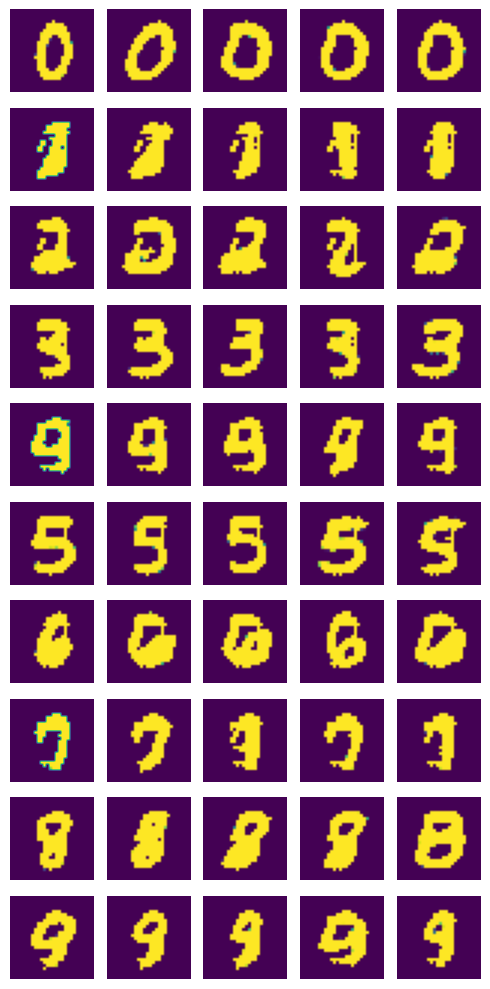

In [59]:
all_imgs = generate_grid(c_vae, device=device, n_samples=5)
show_grid(all_imgs)

In [ ]:
num_classes= 10
c_vae_n = MNISTCvaeNew(10).to(device)
optimizer_n = optim.Adam(c_vae_n.parameters())

In [68]:
n_epochs = 100
train_losses_n = []

for epoch in range(n_epochs):
    c_vae_n.train()
    train_losses_per_epoch = []
    for X_batch, y_batch in train_loader:
        optimizer_n.zero_grad()
        X_batch = X_batch.float()
        X_batch = X_batch.view(X_batch.size(0), -1)

        reconstructed, mu, logsigma = c_vae_n(X_batch.to(device), y_batch.to(device))

        loss, recon, kld = loss_function(reconstructed.cpu(), X_batch.cpu(), mu.cpu(), logsigma.cpu())
        loss.backward()
        optimizer_n.step()
        train_losses_per_epoch.append(loss.item())

    train_losses_n.append(np.mean(train_losses_per_epoch))
    print(f"Epoch = {epoch}, loss = {np.mean(train_losses_per_epoch)}")

Epoch = 0, loss = 490.41652173528286
Epoch = 1, loss = 473.5048013780671
Epoch = 2, loss = 462.420944604284
Epoch = 3, loss = 458.9650068466089
Epoch = 4, loss = 455.5916576263493
Epoch = 5, loss = 452.7699216667777
Epoch = 6, loss = 450.91988566384384
Epoch = 7, loss = 449.0590252906783
Epoch = 8, loss = 448.0607496639813
Epoch = 9, loss = 447.50830061857636
Epoch = 10, loss = 447.01984924446543
Epoch = 11, loss = 446.4732061520314
Epoch = 12, loss = 445.75205333197295
Epoch = 13, loss = 445.31535726518774
Epoch = 14, loss = 444.8873559101812
Epoch = 15, loss = 444.53872205656984
Epoch = 16, loss = 444.31478803752583
Epoch = 17, loss = 444.0968563510919
Epoch = 18, loss = 443.7060052672429
Epoch = 19, loss = 443.4547735023092
Epoch = 20, loss = 443.31387416945336
Epoch = 21, loss = 443.1561072375983
Epoch = 22, loss = 443.01907498292576
Epoch = 23, loss = 442.8525366223951
Epoch = 24, loss = 442.52529360643075
Epoch = 25, loss = 442.0993780530592
Epoch = 26, loss = 441.96474695917385


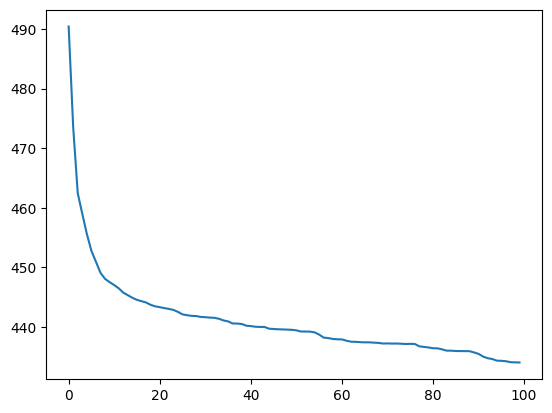

In [69]:
plt.plot(train_losses_n)

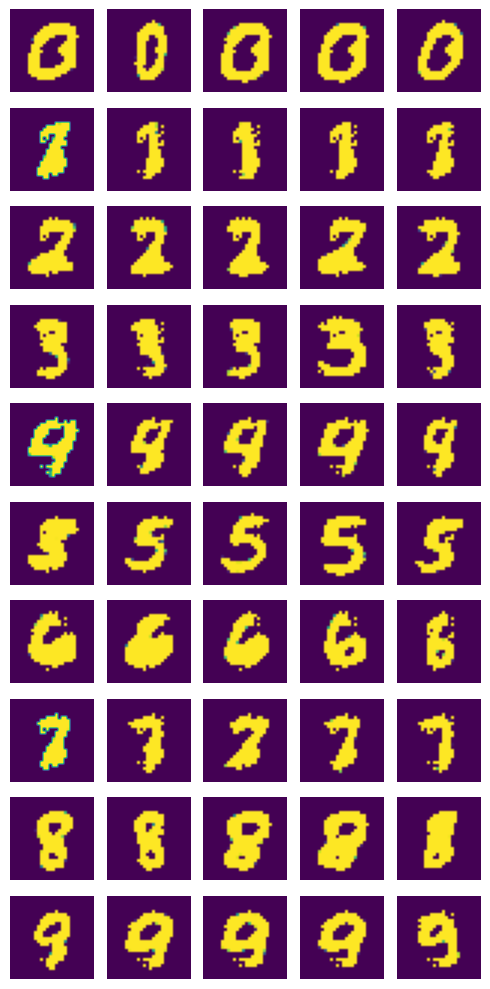

In [87]:
all_imgs = generate_grid(c_vae_n, out_size=18, device=device, n_samples=5)
show_grid(all_imgs)